# Ch04. CoEvents

In [15]:
import numpy as np 
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime as dt
from adv_finance import bars, labeling, utils, sampling

from matplotlib.patches import Rectangle
import  matplotlib.dates as mdates



In [16]:
# TRADE_A233740_DRB = pd.read_parquet('/nfs/data/interim_2018/TRADE_A233740_DRB.parq')
# df = TRADE_A233740_DRB[['open', 'high', 'low', 'close', 'vol']].drop_duplicates()
# df = df.loc[~df.index.duplicated(keep='first')]
# data = df

In [17]:
df = pd.read_parquet('/nfs/data/interim_2018/TRADE_A233740_DB.parq')
df = df.loc[~df.index.duplicated(keep='first')]
data = df


In [18]:
daily_vol = utils.get_daily_vol(data['close'])
threshold = daily_vol.mean() * 0.1
t_events = labeling.cusum_filter(data['close'], threshold)
vert_barriers = labeling.add_vertical_barrier(t_events=t_events, close=data['close'], num_days=1)

In [19]:
%%time
pt_sl = [1,1]
min_ret = 0.01

t_barrier_events = labeling.get_events(close=data['close'], 
                                      t_events=t_events, 
                                      pt_sl=pt_sl, 
                                      num_threads=8, 
                                      target=daily_vol, 
                                      min_ret=min_ret, 
                                      vertical_barrier_times = vert_barriers, 
                                      side_prediction=None)


/nfs/code/adv_finance/adv_finance/labeling/labeling.py:111: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-05-27 01:37:42.356290 100.0%apply_pt_sl_on_t1 done after 0.4 minutes. Remaining 0.0 minutes.


CPU times: user 134 ms, sys: 59.8 ms, total: 194 ms
Wall time: 24.1 s


In [20]:
%%time
num_co_events = sampling.get_num_co_events(timestamps=data.index, t1=t_barrier_events['t1'])
num_co_events = num_co_events.loc[~num_co_events.index.duplicated(keep='first')]
num_co_events = pd.DataFrame(num_co_events, columns=['co'])

CPU times: user 20.6 s, sys: 168 ms, total: 20.8 s
Wall time: 20.3 s


In [21]:
def plot_co_events(d0, df, t_barrier_events, num_co_events, avg_uniq): 
    df0 = df.loc[d0]
    t_barrier_events0 = t_barrier_events.loc[d0]
    num_co_events0 = num_co_events.loc[d0]
    avg_uniq0 = avg_uniq.loc[d0]
    
    
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111)

    plt.title('Triple barriers over the prices')
    plt.plot(df0.index.values, df0.close.values, label='raw_prices', ls='--', color='black')


    # Draw barrier region 
    for i in t_barrier_events0.itertuples(): 
        try: 
            t0, t1, trgt = i.Index, i.t1, i.trgt
            t1 = min(t1, pd.Timestamp(f"{d0} 15:30"))

            x0 = mdates.date2num(t0)
            x1 = mdates.date2num(t1)
            w = x1 - x0 

            y0 = df0.loc[t0].close * (1 - trgt)
            y1 = df0.loc[t0].close * (1 + trgt)
            h = y1 - y0

            rect = Rectangle((x0, y0), w, h, color='black', alpha=0.05)
            ax.add_patch(rect)

            df1 = df0.loc[[t0, t1]].dropna()

            plt.plot(df1.index.values, df1.close.values, label='triple barrier', ls='--', color='red')
            if df1.shape[0] >= 2:
                plt.scatter(df1.index.values[1], df1.close.values[1], marker='o', linewidths=5, color='red')
                
        except Exception as e:
            print(e)

    # Draw num of co-events
    num_co_events0.plot(kind='bar', figsize=(30,10), label='DV')
    
    # Draw average uniqueness
    avg_uniq0.plot(kind='bar', figsize=(30,10), label='AvgUniqueness')
    
    plt.show()

    
    

In [22]:
%%time
avg_uniqueness = sampling.get_sample_tw(t1=t_barrier_events['t1'], num_co_events=num_co_events['co'])
avg_uniq = pd.DataFrame(avg_uniqueness, columns=['avg_uniq'])


CPU times: user 13.6 s, sys: 118 ms, total: 13.7 s
Wall time: 13.5 s


/opt/conda/envs/python372/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


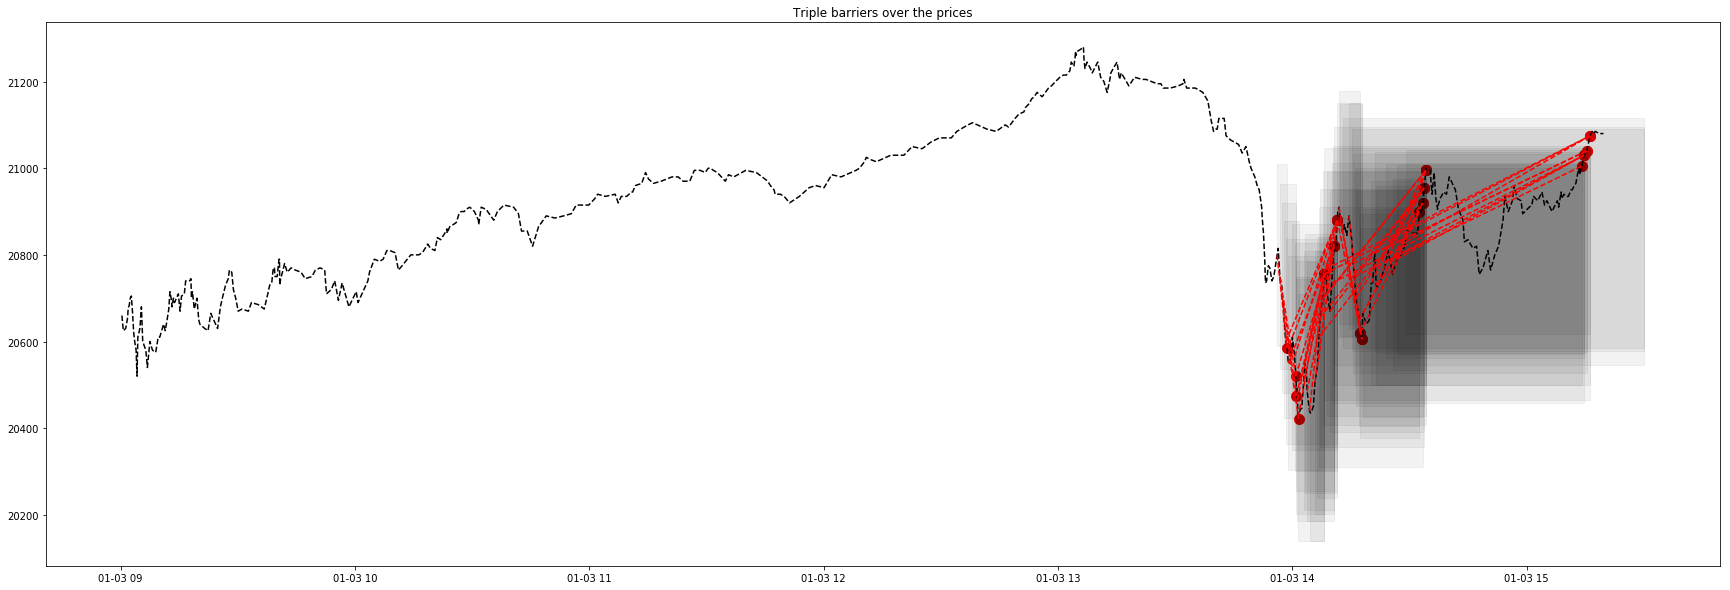

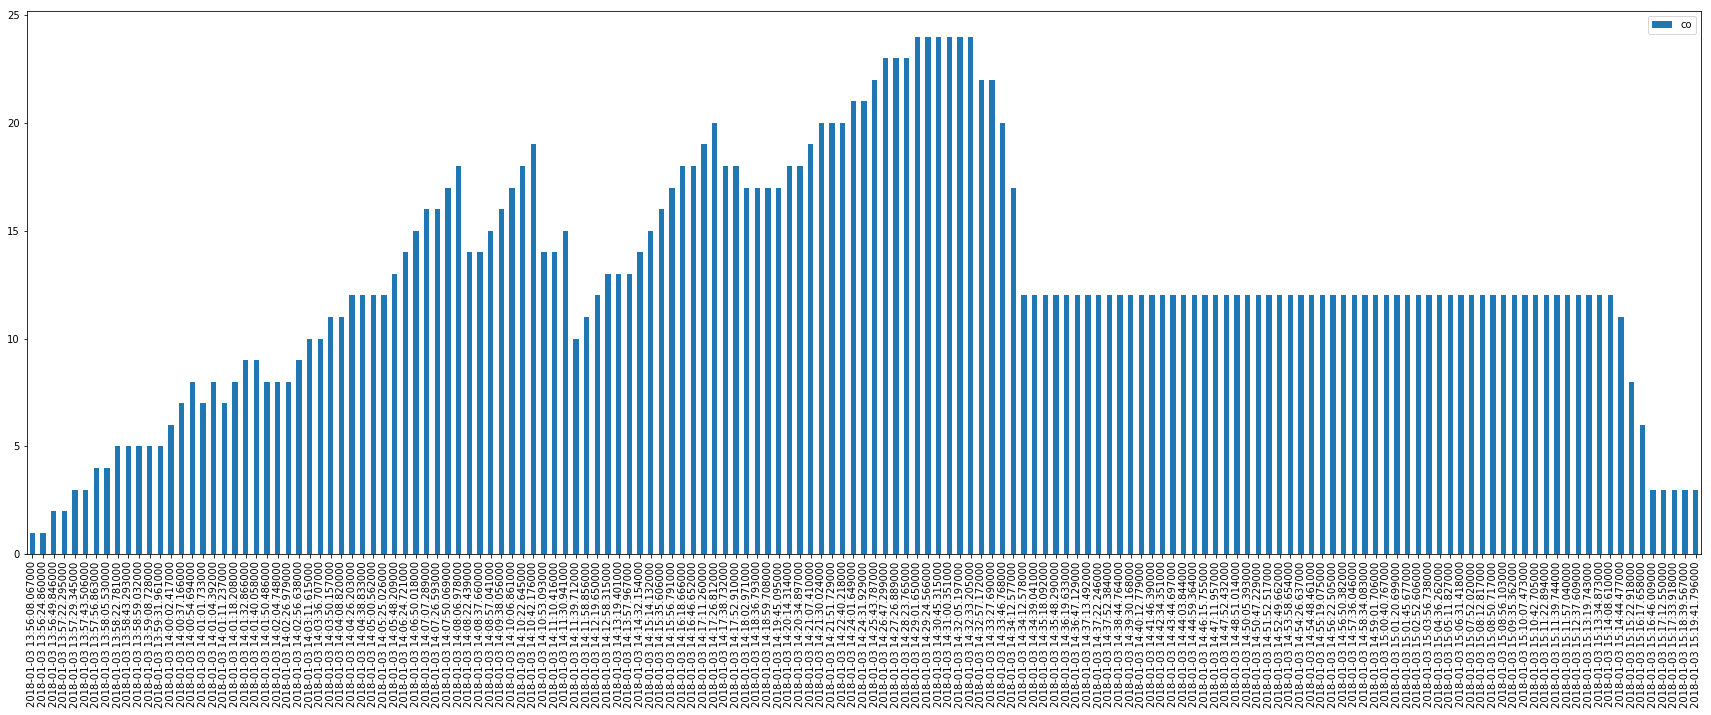

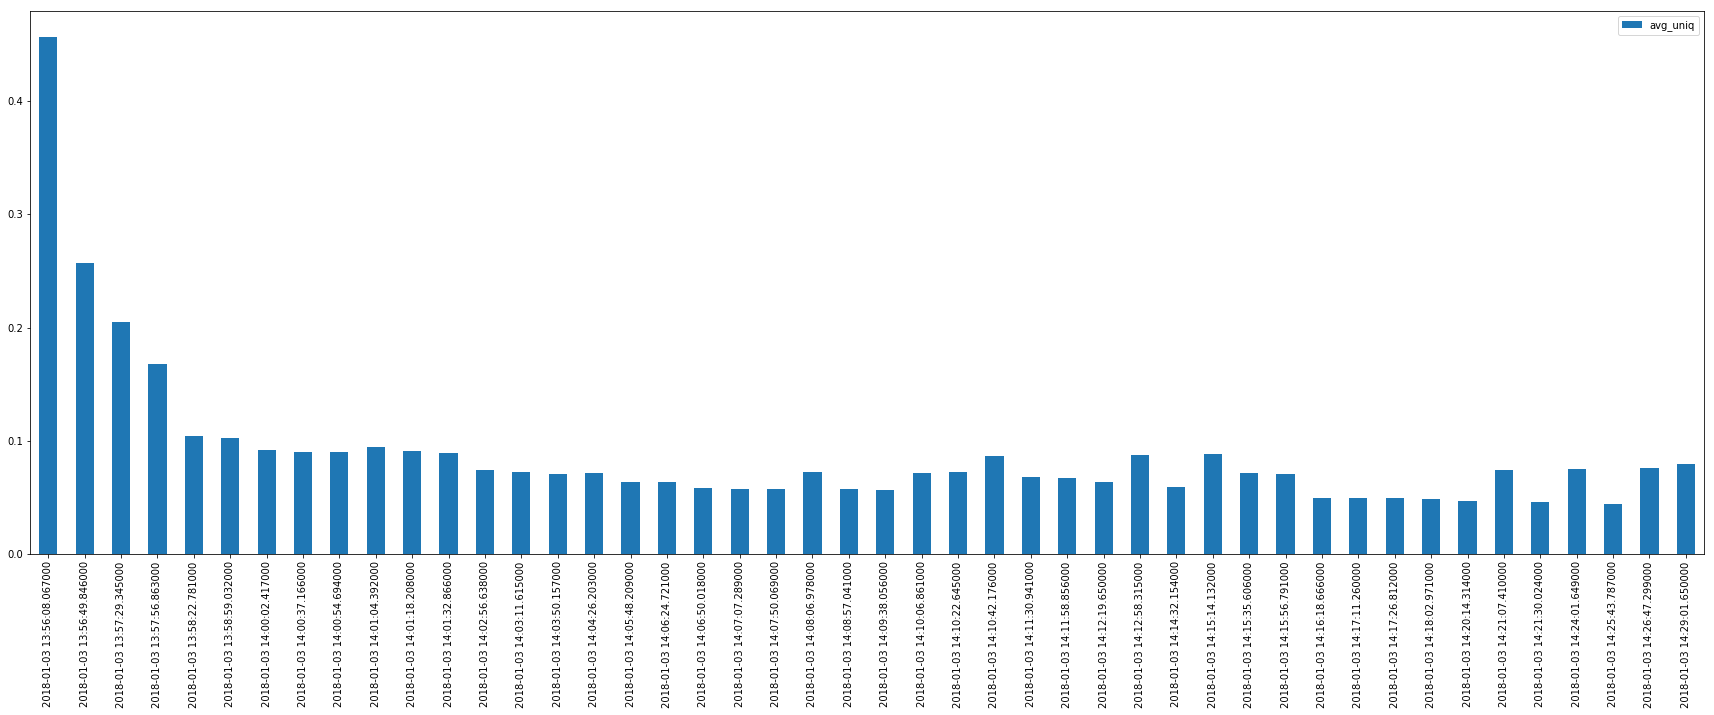

CPU times: user 6.01 s, sys: 2.82 s, total: 8.83 s
Wall time: 5.91 s


In [23]:
%%time
plot_co_events('2018-01-03', df, t_barrier_events, num_co_events, avg_uniq)

/opt/conda/envs/python372/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


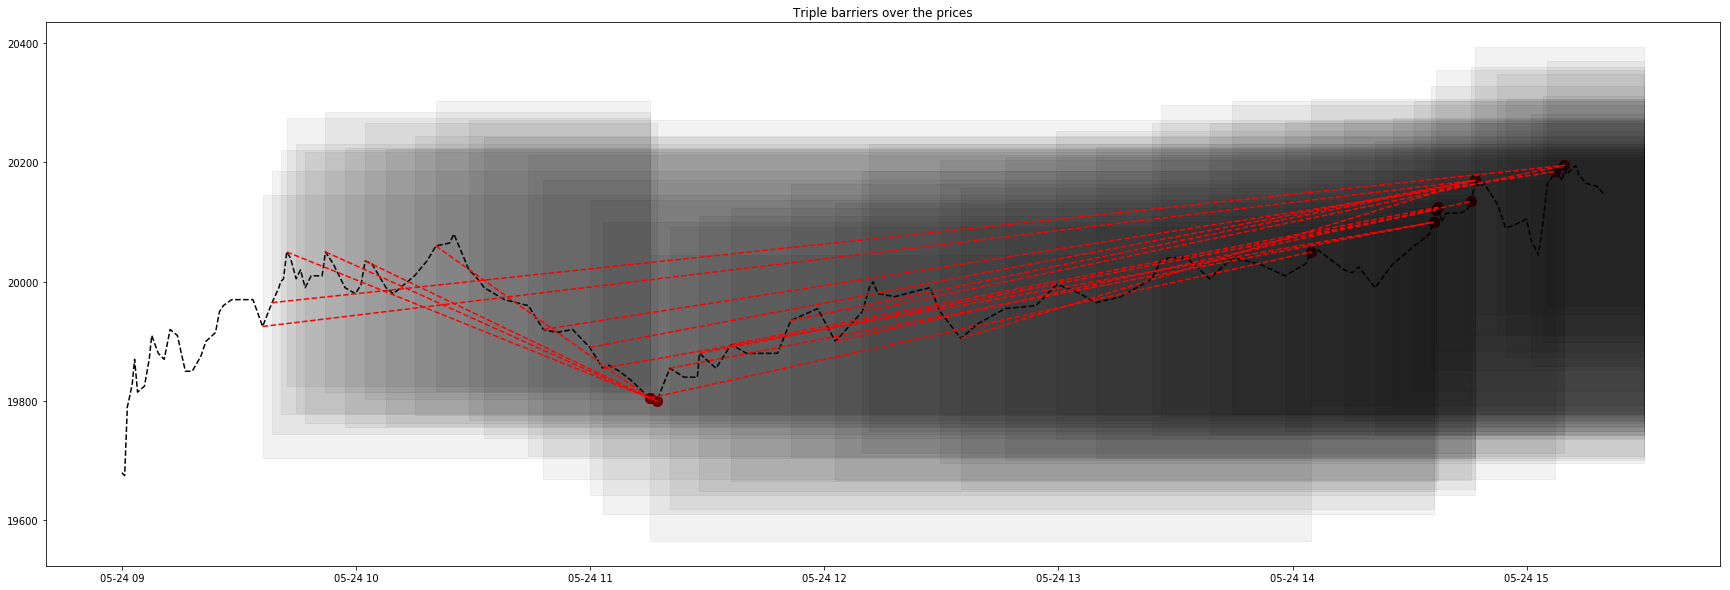

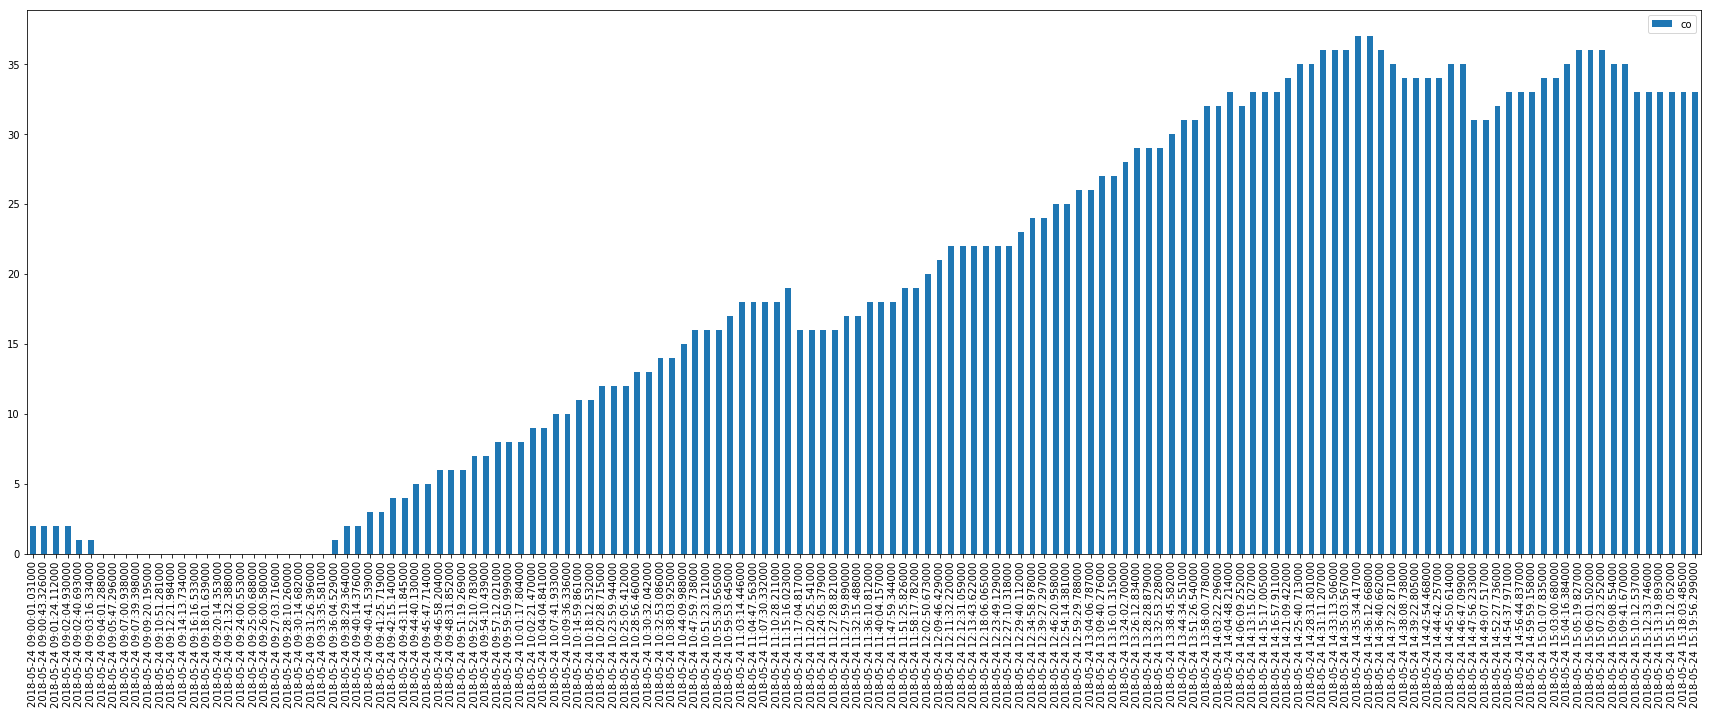

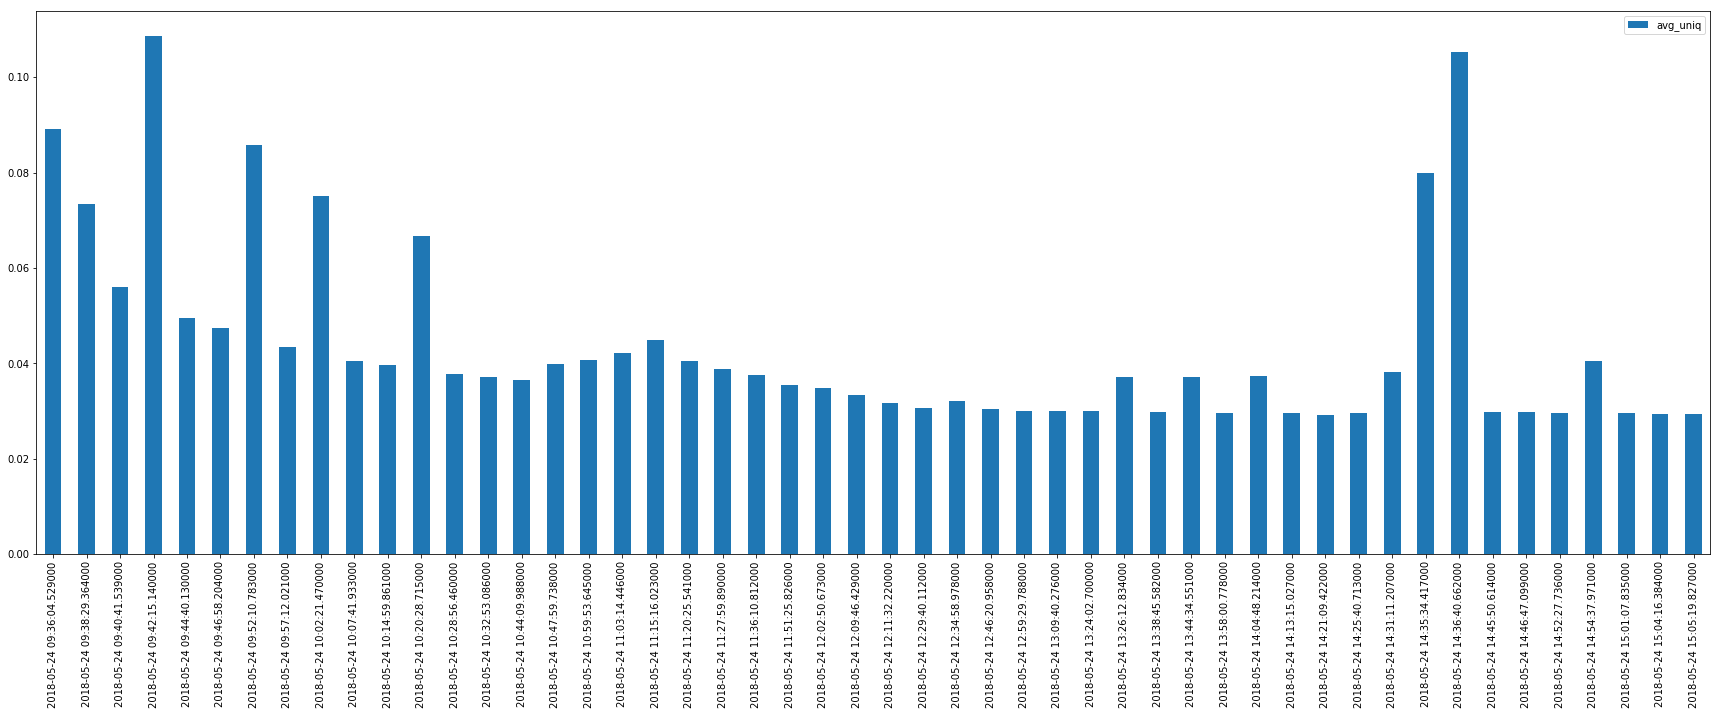

In [24]:
plot_co_events('2018-05-24', df, t_barrier_events, num_co_events, avg_uniq)

/opt/conda/envs/python372/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


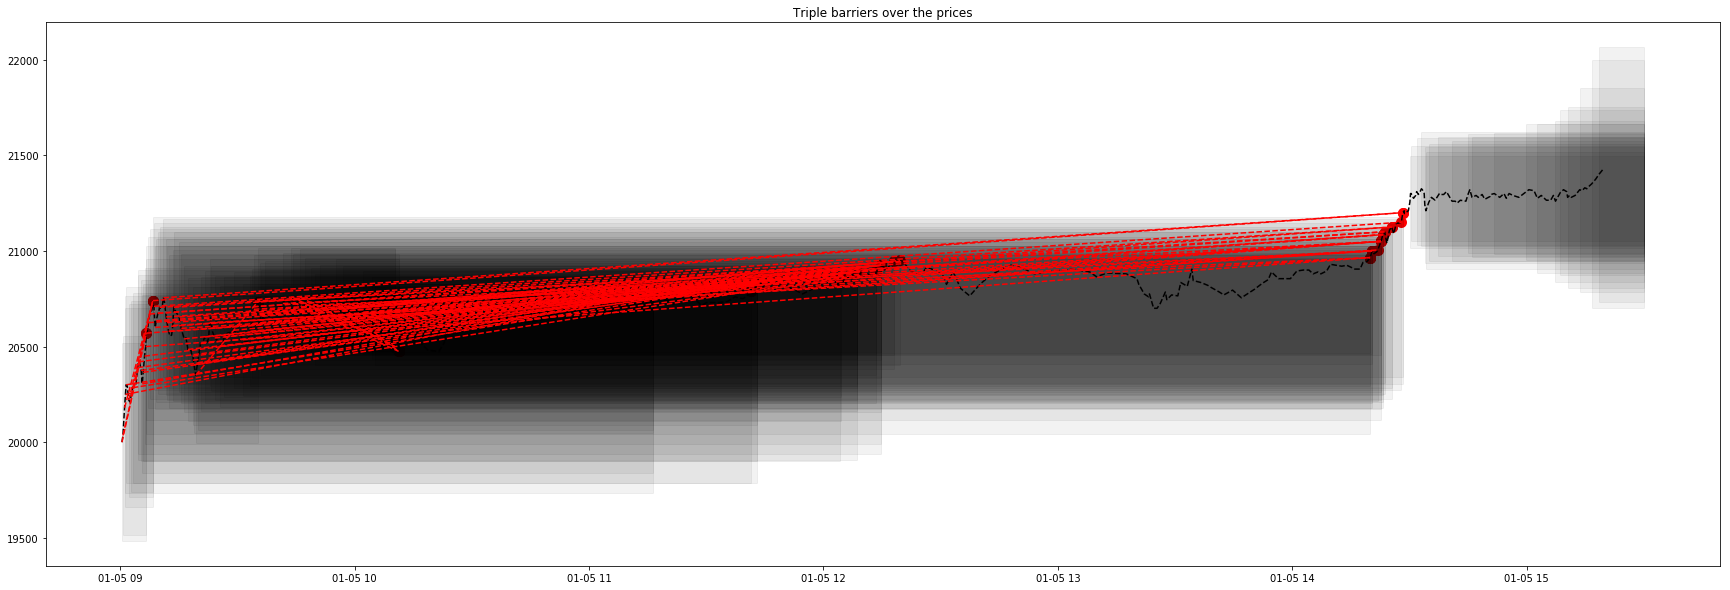

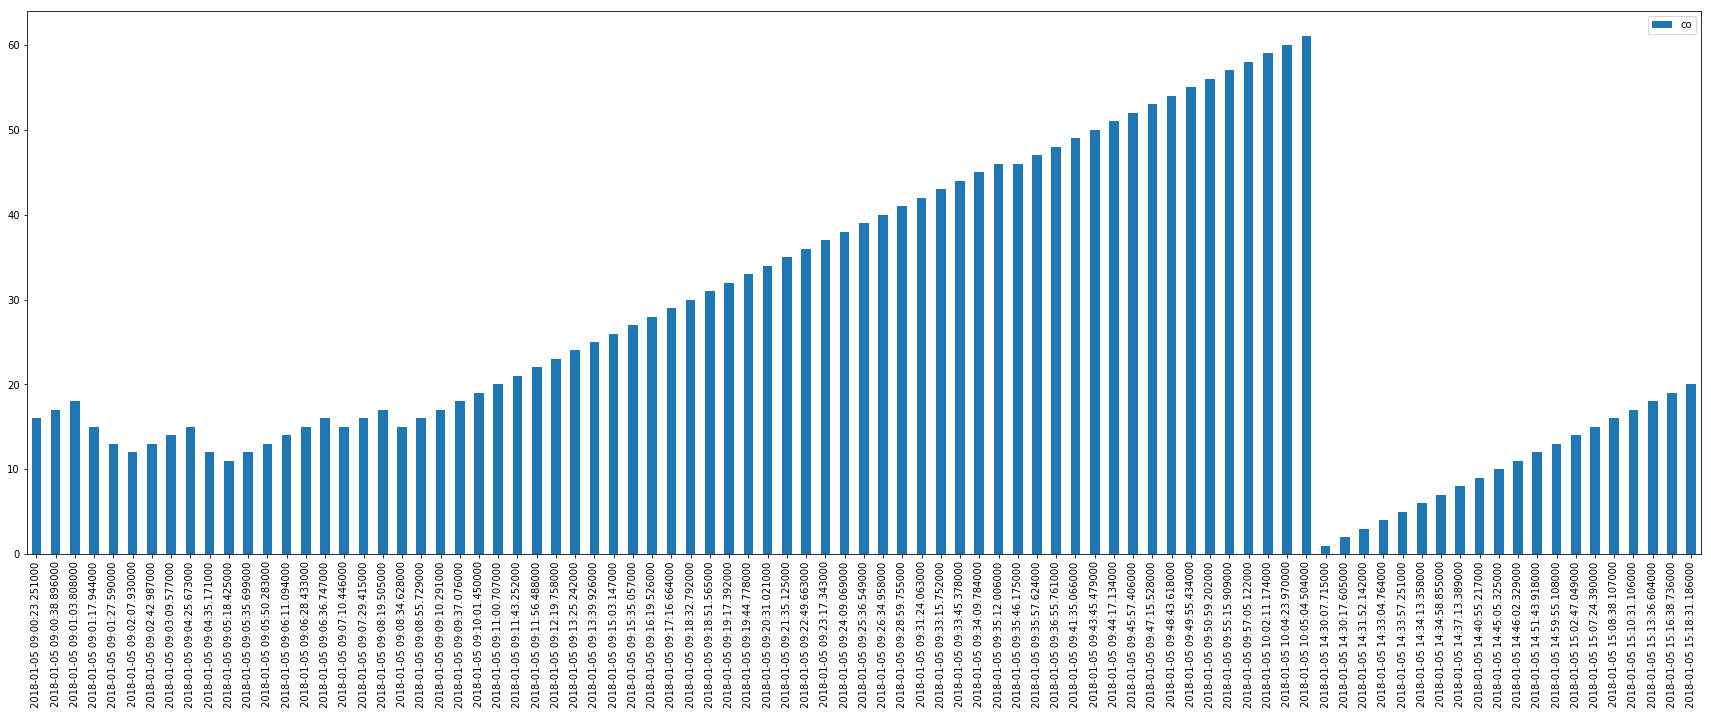

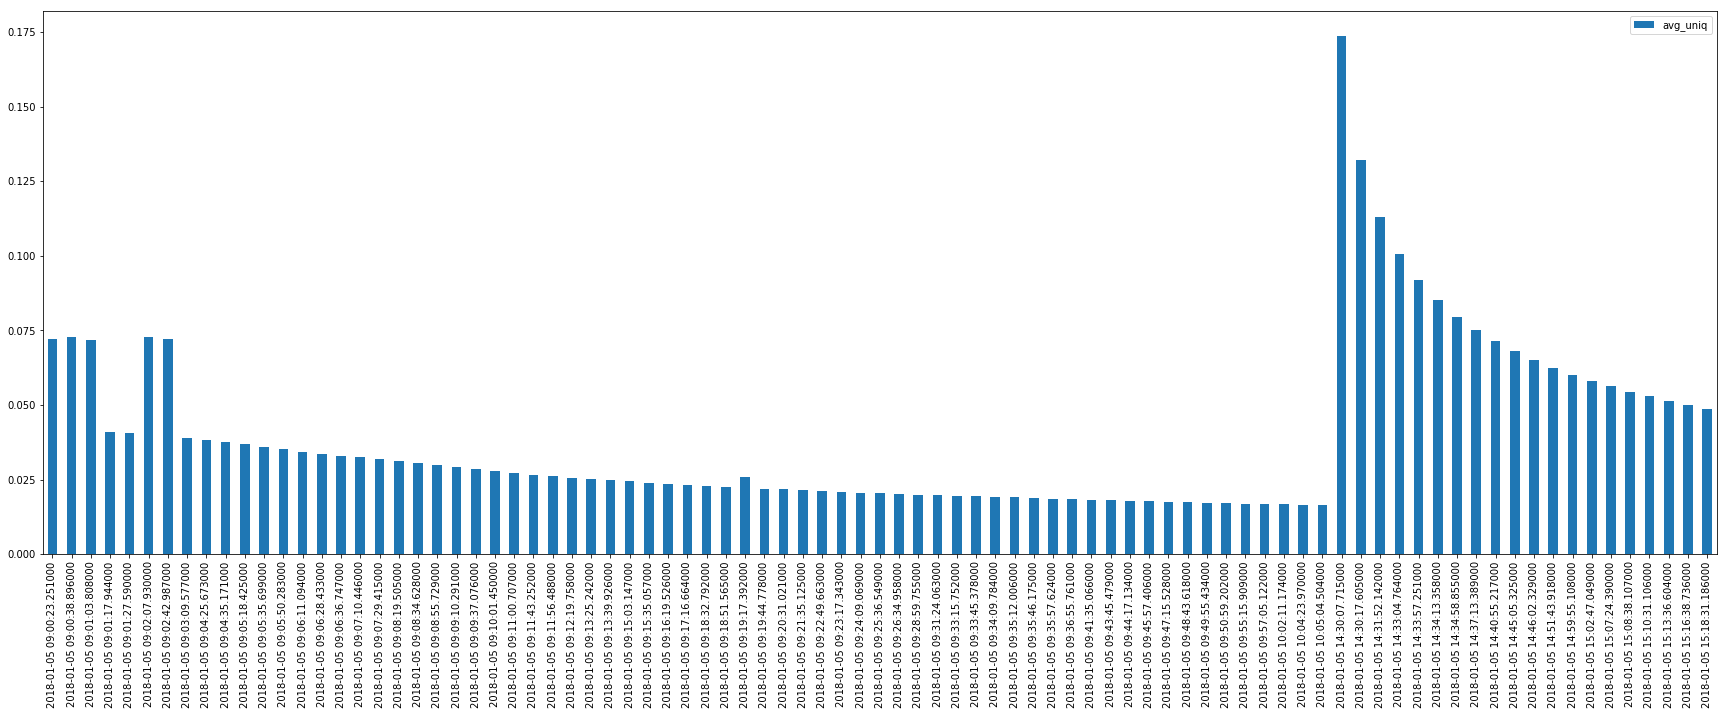

In [34]:
plot_co_events('2018-01-05', df, t_barrier_events, num_co_events, avg_uniq)

# APPENDIX